In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, f1_score, roc_auc_score, roc_curve, fbeta_score, make_scorer
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "fetal_health.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "andrewmvd/fetal-health-classification",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

100%|██████████| 223k/223k [00:00<00:00, 1.31MB/s]

First 5 records: 

   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                             73.0

In [ ]:
features_FEliminar = ["percentage_of_time_with_abnormal_long_term_variability","mean_value_of_short_term_variability"]
features_HEliminar = ["histogram_median","histogram_mean","histogram_mode","histogram_number_of_peaks","histogram_number_of_zeroes","histogram_min","histogram_max","histogram_width"]
df.drop(columns=features_FEliminar, axis=1, inplace=True)
df.drop(columns=features_HEliminar, axis=1, inplace=True)

#Modelage multiclasse

In [ ]:
# Separando features da coluna alvo
X = df.drop('fetal_health', axis=1)
y = df['fetal_health']

# Separação entre treino e teste (usando o padrão 70% x 30%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

In [ ]:
# Como visto, há muitos outliers
# Ao invés de usar o StandardScaler, será usado o RobustScaler, que lida melhor com outliers preciosos
# Caso não seja assim, muito provavelmente valores preciosos serão perdidos
# -> análise de fetos de sinais suspeitos ou patologicos (classes minoritarias)

scaler = RobustScaler()

# Ajuste da parte de treino e de teste
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

##Modelagem sem tunagem

In [ ]:
# Treinar Random Forest
rf = RandomForestClassifier()

rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [ ]:
y_pred_base = rf.predict(X_test_scaled)

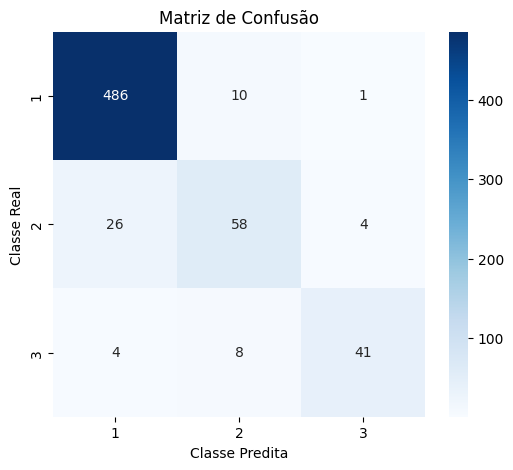

              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       497
         2.0       0.76      0.66      0.71        88
         3.0       0.89      0.77      0.83        53

    accuracy                           0.92       638
   macro avg       0.87      0.80      0.83       638
weighted avg       0.91      0.92      0.91       638

Recall macro: 0.8035143393235341


In [ ]:
cm = confusion_matrix(y_test, y_pred_base)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[1, 2, 3],
    yticklabels=[1, 2, 3]
)
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.title("Matriz de Confusão")
plt.show()
print(classification_report(y_test, y_pred_base))
print(
    "Recall macro:",
    recall_score(y_test, y_pred_base, average='macro')
)

Como o resultado não foi muito satisfatório, iremos tentar tunar os hiperparâmetros e utilizar um treinamento por meio de uma cross-validation

##Modelagem com tunagem

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

Funções que serão utilizadas ao longo da modelagem com tunagem

In [ ]:
def treinamento(params, score, X, y):
  grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    params,
    cv=5,
    scoring=score,
    n_jobs=-1
  )
  grid_search.fit(X, y)
  return grid_search

def report(y_base, y_pred, xaxis, yaxis):
  cm = confusion_matrix(y_base, y_pred)

  plt.figure(figsize=(6, 5))
  sns.heatmap(
      cm,
      annot=True,
      fmt='d',
      cmap='Blues',
      xticklabels=xaxis,
      yticklabels=yaxis
  )
  plt.xlabel("Classe Predita")
  plt.ylabel("Classe Real")
  plt.title("Matriz de Confusão")
  plt.show()
  print(classification_report(y_base, y_pred))
  print(
      "Recall macro:",
      recall_score(y_base, y_pred, average='macro')
  )
  f2_macro = fbeta_score(
    y_base,
    y_pred,
    beta=2,
    average='macro'
  )

  print(f"🎯 F2-score (macro): {f2_macro:.4f}")

def predict_with_thresholds(proba, thresholds, classes):
    preds = []

    idx = {c: i for i, c in enumerate(classes)}

    for p in proba:
        if p[idx[3]] >= thresholds[3]:
            preds.append(3)
        elif p[idx[2]] >= thresholds[2]:
            preds.append(2)
        else:
            preds.append(1)

    return np.array(preds)
def find_best_thresholds(model, X_val, y_val, classes,
                         t2_range=np.linspace(0.1, 0.9, 17),
                         t3_range=np.linspace(0.1, 0.9, 17)):

    proba = model.predict_proba(X_val)

    best_score = -1
    best_thresholds = None

    for t2 in t2_range:
        for t3 in t3_range:
            thresholds = {2: t2, 3: t3}

            y_pred = predict_with_thresholds(
                proba=proba,
                thresholds=thresholds,
                classes=classes
            )

            score = fbeta_score(
                y_val,
                y_pred,
                beta=2,
                average="macro"
            )

            if score > best_score:
                best_score = score
                best_thresholds = thresholds

    return best_thresholds, best_score

###Base de escolha: Recall

In [ ]:
#Dado que o recall não foi satisfatório, agora iremos utilizar ele como base para decisão dos modelos, já que é uma métrica importante
grid_search_rec = treinamento(param_grid, 'recall', X_train_scaled, y_train)
print(f"🏆 Melhores parâmetros:")
for param, value in grid_search_rec.best_params_.items():
    print(f"  {param}: {value}")

🏆 Melhores parâmetros:
  class_weight: None
  criterion: gini
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100


In [ ]:
# Treinar Random Forest
rf_rec = grid_search_rec.best_estimator_

rf_rec.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_rec = rf_rec.predict(X_test_scaled)

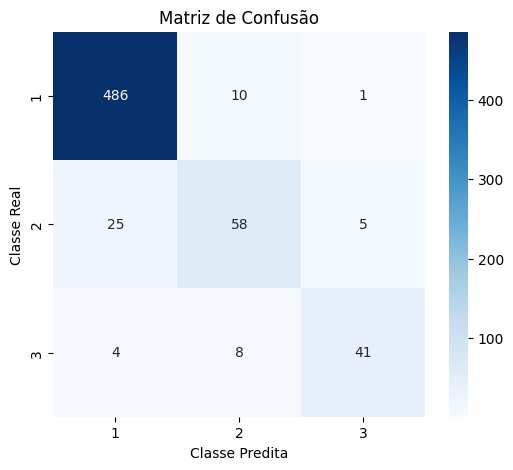

              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       497
         2.0       0.76      0.66      0.71        88
         3.0       0.87      0.77      0.82        53

    accuracy                           0.92       638
   macro avg       0.86      0.80      0.83       638
weighted avg       0.91      0.92      0.91       638

Recall macro: 0.8035143393235341


In [ ]:
report(y_test, y_pred_rec, [1, 2, 3], [1, 2, 3])

Alterando o grid search, para levar em conta o desbalanceamento das classes

In [ ]:
#Cálculo das proporções das classes
y_train.value_counts()

,count
fetal_health,
1.0,1158
2.0,207
3.0,123


In [ ]:
pesos = []
ref = y_train.value_counts().max()
for val in y_train.value_counts():
    if(val != ref):
        pesos.append(ref/val)
    else:
        pesos.append(1)
print(pesos)

[1, 5.594202898550725, 9.414634146341463]


In [ ]:
param_grid_wgt = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [
        None,
        {1:1, 2:3, 3:6},
        {1:1, 2:4, 3:8},
        {1:1, 2:5, 3:9}
    ]
}


###Base de escolha: Recall macro + pesos

In [ ]:
grid_search_rm = treinamento(param_grid_wgt, 'recall_macro', X_train_scaled, y_train)

rf_best = grid_search_rm.best_estimator_

print("🏆 Melhores parâmetros:")
for k, v in grid_search_rm.best_params_.items():
    print(f"{k}: {v}")

🏆 Melhores parâmetros:
class_weight: {1: 1, 2: 3, 3: 6}
criterion: gini
max_depth: None
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 5
n_estimators: 200


In [ ]:
y_prob = rf_best.predict_proba(X_test_scaled)
classes = rf_best.classes_   # MUITO IMPORTANTE


In [ ]:
best_thresholds, best_f2 = find_best_thresholds(
    model=rf_best,
    X_val=X_val_scaled,
    y_val=y_val,
    classes=[1, 2, 3]
)

In [ ]:
y_pred_custom = predict_with_thresholds(
    proba=y_prob,
    thresholds=best_thresholds,
    classes=rf_best.classes_
)


📊 Classification Report:
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.95       497
         2.0       0.67      0.72      0.69        88
         3.0       0.80      0.81      0.80        53

    accuracy                           0.90       638
   macro avg       0.81      0.82      0.82       638
weighted avg       0.91      0.90      0.90       638



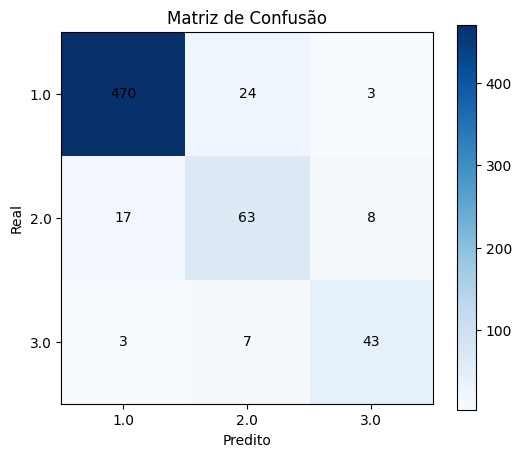

In [ ]:
report(y_test, y_pred_custom, [1, 2, 3], [1, 2, 3])


###Base de escolha do modelo: F2 score + pesos

In [ ]:
# 1️⃣ Scorer F2
f2_macro = make_scorer(
    fbeta_score,
    beta=2,
    average='macro'
)
grid_search_f2 = treinamento(param_grid_wgt, f2_macro, X_train_scaled, y_train)

rf_f2 = grid_search_f2.best_estimator_

print("🏆 Melhores parâmetros:")
for k, v in grid_search_f2.best_params_.items():
    print(f"{k}: {v}")

🏆 Melhores parâmetros:
class_weight: {1: 1, 2: 3, 3: 6}
criterion: gini
max_depth: None
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 2
n_estimators: 200


In [ ]:
# 3️⃣ Probabilidades no conjunto de TESTE
y_prob_f2 = rf_f2.predict_proba(X_test_scaled)

# 4️⃣ Classes (ordem correta)
classes = rf_f2.classes_

# 5️⃣ Encontrar thresholds no conjunto de VALIDAÇÃO
best_thresholds_f2, best_f2_f2 = find_best_thresholds(
    model=rf_f2,
    X_val=X_val_scaled,
    y_val=y_val,
    classes=classes
)

In [ ]:
print("🎯 Melhores thresholds:", best_thresholds_f2)
print("🏆 Melhor F2 macro (val):", best_f2_f2)

🎯 Melhores thresholds: {2: np.float64(0.25), 3: np.float64(0.45000000000000007)}
🏆 Melhor F2 macro (val): 0.9166656377599484


In [ ]:
# 6️⃣ Predição final com thresholds aprendidos
y_pred_f2 = predict_with_thresholds(
    proba=y_prob_f2,
    thresholds=best_thresholds_f2,
    classes=classes
)

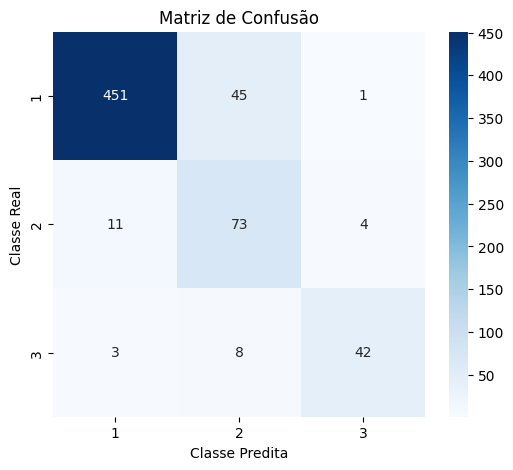

              precision    recall  f1-score   support

         1.0       0.97      0.91      0.94       497
         2.0       0.58      0.83      0.68        88
         3.0       0.89      0.79      0.84        53

    accuracy                           0.89       638
   macro avg       0.81      0.84      0.82       638
weighted avg       0.91      0.89      0.89       638

Recall macro: 0.8431476509140609


In [ ]:
report(y_test, y_pred_f2, [1, 2, 3], [1, 2, 3])

##Feature importance

Analisando quais features foram mais importantes para o modelo baseado no melhor modelo que foi o que teve como base de escolha f2_score

In [ ]:
# Feature importance
feature_names = X.columns
importances = rf_f2.feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
print(f"\n📊 Feature Importance (Random Forest):")
for i in range(min(5, len(indices))):
    idx = indices[i]
    print(f"  {feature_names[idx]}: {importances[idx]:.3f}")


📊 Feature Importance (Random Forest):
  abnormal_short_term_variability: 0.260
  mean_value_of_long_term_variability: 0.127
  accelerations: 0.118
  baseline value: 0.111
  histogram_variance: 0.107


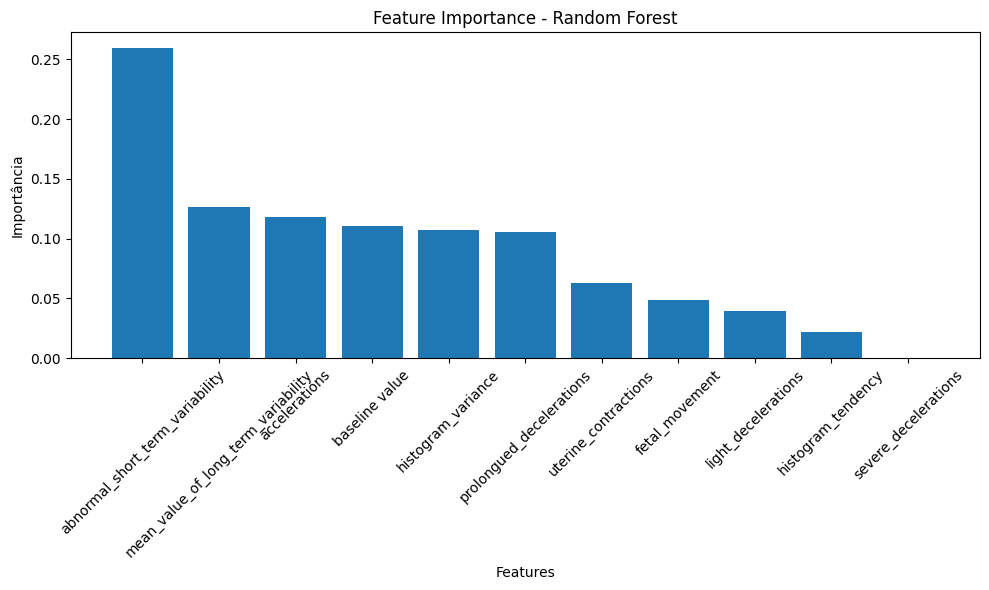

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xlabel('Features')
plt.ylabel('Importância')
plt.title('Feature Importance - Random Forest')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

#Modelage binária

In [ ]:
# Separando features da coluna alvo
X = df.drop('fetal_health', axis=1)
y = df['fetal_health']

# Binarização do problema (normal x anormal)
y = y.replace(3, 2)

df['fetal_health'] = y


# Separação entre treino e teste (usando o padrão 70% x 30%)
X_temp, X_test_bin, y_temp, y_test_bin = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

In [ ]:
# Como visto, há muitos outliers
# Ao invés de usar o StandardScaler, será usado o RobustScaler, que lida melhor com outliers preciosos
# Caso não seja assim, muito provavelmente valores preciosos serão perdidos
# -> análise de fetos de sinais suspeitos ou patologicos (classes minoritarias)

scaler = RobustScaler()

# Ajuste da parte de treino e de teste
X_train_scaled_bin = scaler.fit_transform(X_train_bin)
X_val_scaled_bin = scaler.transform(X_val_bin)
X_test_scaled_bin = scaler.transform(X_test_bin)

##Modelagem sem tunagem

In [ ]:
# Treinar Random Forest
rf_bin = RandomForestClassifier()

rf_bin.fit(X_train_scaled_bin, y_train_bin)

RandomForestClassifier()

In [ ]:
y_pred_bin = rf_bin.predict(X_test_scaled_bin)

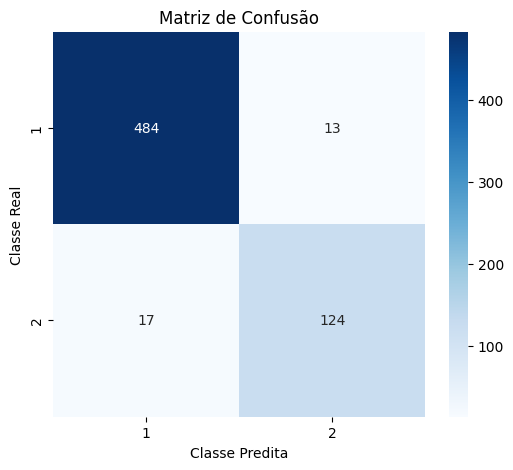

              precision    recall  f1-score   support

         1.0       0.97      0.97      0.97       497
         2.0       0.91      0.88      0.89       141

    accuracy                           0.95       638
   macro avg       0.94      0.93      0.93       638
weighted avg       0.95      0.95      0.95       638

Recall macro: 0.9266378412317879
🎯 F2-score (macro): 0.9284


In [ ]:
report(y_test_bin, y_pred_bin, [1, 2], [1, 2])

##Modelagem com tunagem

In [ ]:
ref = y_train_bin.value_counts().max()
for val in y_train_bin.value_counts():
    if(val != ref):
        print(ref/val)

3.507575757575758


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}
param_grid_wgt_bin = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [
        None,
        {1:1, 2:2},
        {1:1, 2:3},
        {1:1, 2:4}
    ]
}

Fazendo um grid search tendo como critério de decisão a acurácia

In [ ]:
def predict_with_thresholds_binary(proba, threshold, classes, positive_class):
    preds = []

    idx = {c: i for i, c in enumerate(classes)}
    pos_idx = idx[positive_class]

    # classe negativa = a outra
    negative_class = [c for c in classes if c != positive_class][0]

    for p in proba:
        if p[pos_idx] >= threshold:
            preds.append(positive_class)
        else:
            preds.append(negative_class)

    return np.array(preds)
from sklearn.metrics import fbeta_score

def find_best_threshold_binary(
    model,
    X_val,
    y_val,
    classes,
    positive_class,
    t_range=np.linspace(0.05, 0.95, 37)
):
    proba = model.predict_proba(X_val)

    best_score = -1
    best_threshold = None

    for t in t_range:
        y_pred = predict_with_thresholds_binary(
            proba=proba,
            threshold=t,
            classes=classes,
            positive_class=positive_class
        )

        score = fbeta_score(
            y_val,
            y_pred,
            beta=2,
            average="binary",
            pos_label=positive_class
        )

        if score > best_score:
            best_score = score
            best_threshold = t

    return best_threshold, best_score


###Base de escolha: Recall

In [ ]:
grid_search_rec_bin = treinamento(param_grid, 'recall', X_train_scaled_bin, y_train_bin)
print(f"🏆 Melhores parâmetros:")
for param, value in grid_search_rec_bin.best_params_.items():
    print(f"  {param}: {value}")

🏆 Melhores parâmetros:
  class_weight: None
  criterion: entropy
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 100


In [ ]:
# Treinar Random Forest
rf_rec = grid_search_rec_bin.best_estimator_

rf_rec.fit(X_train_scaled_bin,  y_train_bin)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       random_state=42)

In [ ]:
y_pred_rec_bin = rf_rec.predict(X_test_scaled_bin)

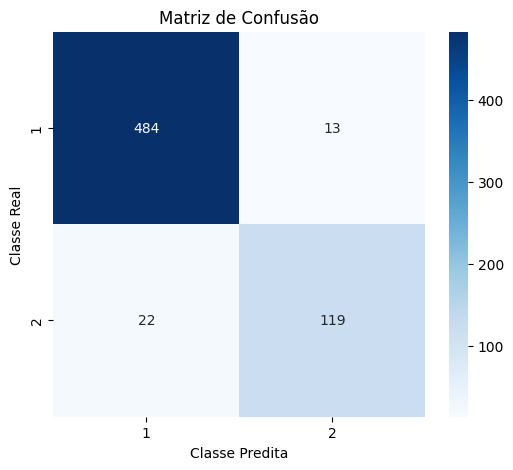

              precision    recall  f1-score   support

         1.0       0.96      0.97      0.97       497
         2.0       0.90      0.84      0.87       141

    accuracy                           0.95       638
   macro avg       0.93      0.91      0.92       638
weighted avg       0.94      0.95      0.94       638

Recall macro: 0.9089073447778873
🎯 F2-score (macro): 0.9126


In [ ]:
report(y_test_bin, y_pred_rec_bin, [1, 2], [1, 2])

###Base de escolha: Recall macro + pesos

In [ ]:
grid_search_rm_bin = treinamento(param_grid_wgt_bin, 'recall_macro', X_train_scaled_bin, y_train_bin)

rf_best_bin = grid_search_rm_bin.best_estimator_

print("🏆 Melhores parâmetros:")
for k, v in grid_search_rm_bin.best_params_.items():
    print(f"{k}: {v}")

🏆 Melhores parâmetros:
class_weight: {1: 1, 2: 3}
criterion: entropy
max_depth: None
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 5
n_estimators: 200


In [ ]:
y_rec_bin = rf_best_bin.predict_proba(X_test_scaled_bin)
classes = rf_best_bin.classes_   # MUITO IMPORTANTE


In [ ]:
best_thresholds_rec_bin, best_f2_rec_bin = find_best_threshold_binary(
    model=rf_best_bin,
    X_val=X_val_scaled_bin,
    y_val=y_val_bin,
    classes=classes,
    positive_class=2
)

In [ ]:
y_pred_rec_bin = predict_with_thresholds_binary(
    proba=y_rec_bin,
    threshold=best_thresholds_rec_bin,
    classes=rf_best_bin.classes_,
    positive_class=2
)

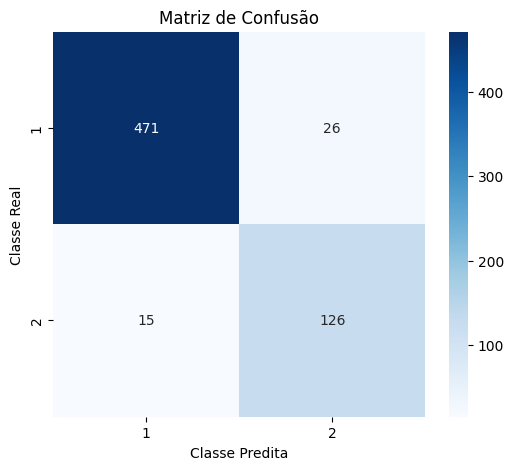

              precision    recall  f1-score   support

         1.0       0.97      0.95      0.96       497
         2.0       0.83      0.89      0.86       141

    accuracy                           0.94       638
   macro avg       0.90      0.92      0.91       638
weighted avg       0.94      0.94      0.94       638

Recall macro: 0.9206515689883985
🎯 F2-score (macro): 0.9159


In [ ]:
report(y_test_bin, y_pred_rec_bin, [1, 2], [1, 2])


###Base de escolha do modelo: F2 score + pesos

In [ ]:
# 1️⃣ Scorer F2
f2_macro = make_scorer(
    fbeta_score,
    beta=2,
    average='macro'
)
grid_search_f2_bin = treinamento(param_grid_wgt_bin, f2_macro, X_train_scaled_bin, y_train_bin)

rf_f2_bin = grid_search_f2_bin.best_estimator_

print("🏆 Melhores parâmetros:")
for k, v in grid_search_f2_bin.best_params_.items():
    print(f"{k}: {v}")

🏆 Melhores parâmetros:
class_weight: None
criterion: gini
max_depth: 10
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 100


In [ ]:
# 3️⃣ Probabilidades no conjunto de TESTE
y_prob_f2_bin = rf_f2_bin.predict_proba(X_test_scaled_bin)

# 4️⃣ Classes (ordem correta)
classes_bin = rf_f2_bin.classes_

# 5️⃣ Encontrar thresholds no conjunto de VALIDAÇÃO
best_thresholds_f2_bin, best_f2_f2_bin = find_best_threshold_binary(
    model=rf_f2_bin,
    X_val=X_val_scaled_bin,
    y_val=y_val_bin,
    classes=classes_bin,
    positive_class=2
)

In [ ]:
print("🎯 Melhores thresholds:", best_thresholds_f2_bin)
print("🏆 Melhor F2 macro (val):", best_f2_f2_bin)

🎯 Melhores thresholds: 0.175
🏆 Melhor F2 macro (val): 0.8873239436619719


In [ ]:
# 6️⃣ Predição final com thresholds aprendidos
y_pred_f2_bin = predict_with_thresholds_binary(
    proba=y_prob_f2_bin,
    threshold=best_thresholds_f2_bin,
    classes=classes_bin,
    positive_class=2
)

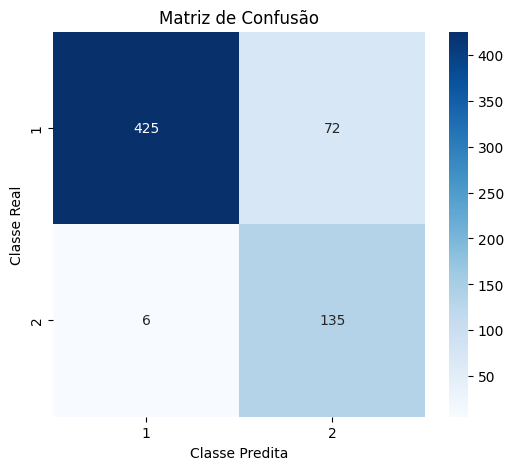

              precision    recall  f1-score   support

         1.0       0.99      0.86      0.92       497
         2.0       0.65      0.96      0.78       141

    accuracy                           0.88       638
   macro avg       0.82      0.91      0.85       638
weighted avg       0.91      0.88      0.88       638

Recall macro: 0.906288796609444
🎯 F2-score (macro): 0.8770


In [ ]:
report(y_test_bin, y_pred_f2_bin, [1, 2], [1, 2])

##Feature Importance

Analisando quais features foram mais importantes para o modelo

In [ ]:
# Feature importance
feature_names = X.columns
importances = rf_acc.feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
print(f"\n📊 Feature Importance (Random Forest):")
for i in range(min(5, len(indices))):
    idx = indices[i]
    print(f"  {feature_names[idx]}: {importances[idx]:.3f}")


📊 Feature Importance (Random Forest):
  abnormal_short_term_variability: 0.309
  accelerations: 0.133
  uterine_contractions: 0.111
  histogram_variance: 0.101
  baseline value: 0.094


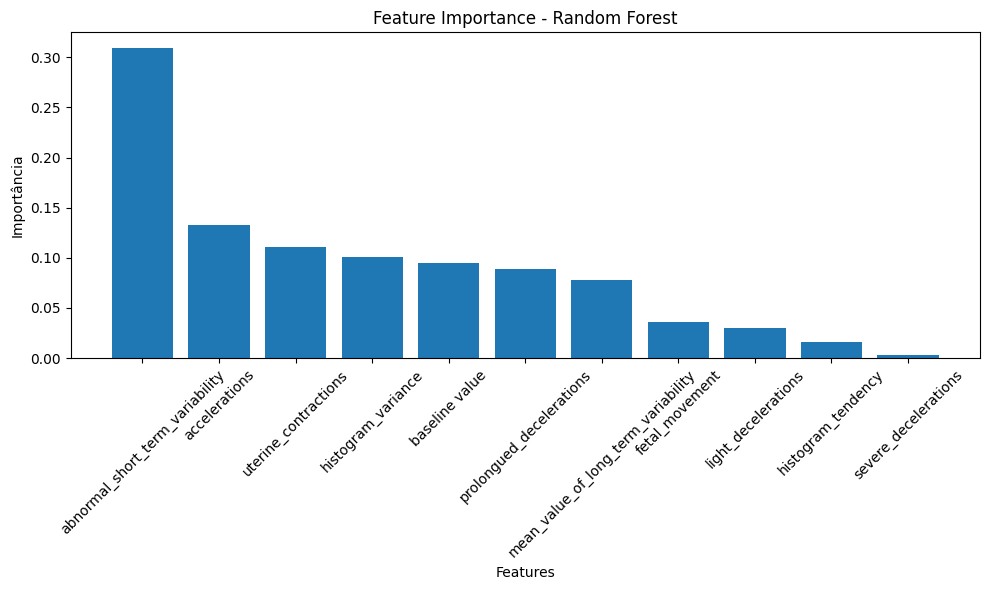

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xlabel('Features')
plt.ylabel('Importância')
plt.title('Feature Importance - Random Forest')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()